# Equation 4 Hamiltonian - ZXW Diagram and Eigenvalues

This notebook creates a ZXW diagram representing equation 4 from paper arxiv:24.08:
$$Ĥ^{jk} = F_jk σ̂_+^j σ̂_-^k + F_kj σ̂_-^j σ̂_+^k$$

Which decomposes the off diagonal into Pauli strings as: $(F_{jk}/2) * (X_j X_k - Y_j Y_k)$

We then compute the eigenvalues of this Hamiltonian using the ZXW method.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import ishermitian
import sys
import os
import pyzx as zx

# Import ZXW functions

from pauli_hamiltonian_zx import PauliHamiltonianZX


from cor_decay_zxw import (
    compute_F_jk_equation5,
    create_equation4_hamiltonian,
    setup_positions_3d_grid,
    setup_positions_2d_grid
)

## Setup: Atom Positions and F_jk Matrix


### Parameters


In [ ]:
N = 4 # Number of atoms (small for visualization)
lambda_val = 2.0  # Wavelength
gam = 2.0  # Decay rate Γ
m = 100  # 1d-size of array relative to lambda

### Setting up 2D Grid Positions

In [ ]:
two_dim_positions = setup_positions_2d_grid(N, m, lambda_val)
print(two_dim_positions)
for i in range(len(two_dim_positions[0])):
    print(f"  Atom {i}: ({two_dim_positions[0][i]:.3f}, {two_dim_positions[1][i]:.3f})")

# Compute $F_{jk}$ matrix using equation 5

In [ ]:

F_matrix = compute_F_jk_equation5(*two_dim_positions, lambda_val, gam)

print(f"F_jk matrix shape: {F_matrix.shape}")
print(f"\nF_jk matrix (real part):")
print(F_matrix)

print(f"\nSample coupling values:")
for j in range(min(3, N)):
    for k in range(j+1, min(3, N)):
        print(f"  F_{j}{k} = {F_matrix[j, k].real:.6f} + {F_matrix[j, k].imag:.6f}i")


F_jk matrix shape: (4, 4)

F_jk matrix (real part):
[[0.+0.j         0.-0.0000152j  0.-0.0000152j  0.+0.00327551j]
 [0.-0.0000152j  0.+0.j         0.+0.00327551j 0.-0.0000152j ]
 [0.-0.0000152j  0.+0.00327551j 0.+0.j         0.-0.0000152j ]
 [0.+0.00327551j 0.-0.0000152j  0.-0.0000152j  0.+0.j        ]]

Sample coupling values:
  F_01 = 0.000000 + -0.000015i
  F_02 = 0.000000 + -0.000015i
  F_12 = 0.000000 + 0.003276i


## Creating Pauli string Hamiltonian for equation 4
### It uses: 
$H_jk = (F_{jk}/2) * (X_j X_k + Y_j Y_k),$   $j \neq k$

$H_jj = -i (\Gamma/2) * (Z_j + I_j)$

In [15]:
pauli_strings = create_equation4_hamiltonian(N, F_matrix, gamma=gam)

# UNCOMMENT to see all Pauli strings

In [ ]:
# print(f"Number of Pauli terms: {len(pauli_strings)}")
# print(f"\nFirst 6 Pauli strings (showing X_j X_k and -Y_j Y_k pairs):")

# for i, (coeff, gates) in enumerate(pauli_strings[:]):
#     print(f"  {i+1}: {coeff:.6f} * {gates}")


# Create ZXW Hamiltonian
Using list of Pauli Strings

In [ ]:
hamiltonian = PauliHamiltonianZX(pauli_strings)
print(f"\nTotal qubits: {hamiltonian.total_qubits}")

# Build the ZXW diagram

In [ ]:
print("Building ZXW diagram...")
graph = hamiltonian.build_graph()
print("Graph built successfully")

Building ZXW diagram...
Graph built successfully


# Vizualize our Graph

In [ ]:
print("\nDisplaying ZXW diagram:")
zx.draw(graph)

# Choosing Trotter Parameters

In [ ]:
vals =  [[]]
max_steps = 20
t_f = 3
t_vals = np.linspace(0.0, t_f, 30)

# Building Trotter Graphs at Different Times

### Simulation of Time Evolution Using Trotterization in ZX Calculus

This code snippet implements a numerical simulation of quantum time evolution for an $N$-body system using the **ZX Calculus** to handle tensor contractions.

#### 1. First-Order Trotter Decomposition
The core theoretical component is the **First-Order Trotter-Suzuki Decomposition**. When simulating a Hamiltonian $H = \sum_k H_k$ (where terms $H_k$ may not commute) over a time $t$, the unitary evolution operator $U(t) = e^{-iHt}$ is approximated by slicing the time into $n$ small steps:

$$
U(t) = e^{-i \sum_k H_k t} \approx \left( \prod_k e^{-i H_k \frac{t}{n}} \right)^n
$$

* **In your code:** The variable `steps` represents $n$.
* **The approximation:** This introduces an error of order $O(t^2/n)$. Increasing `steps` (the inner loop) refines the temporal resolution, making the digital quantum simulation closer to the continuous physical evolution.
* **Graph Construction:** The function `hamiltonian.build_trotter_graph(steps=steps, time=t)` constructs a ZX diagram representing this product of exponentials repeated `steps` times.

#### 2. Code Logic Breakdown

* **State Preparation & Projection (`apply_state`, `apply_effect`):**
    The code calculates the transition amplitude (or survival probability) of the initial state.
    * `gc.apply_state(excited)`: Initializes the system in the state $|\psi_{in}\rangle$ (e.g., $|1\rangle^{\otimes N}$).
    * `gc.apply_effect(excited)`: Post-selects (projects) onto the state $\langle \psi_{out}|$ (same as input here).
    * **Physical Meaning:** This computes the scalar quantity $\langle \psi_{excited} | U(t) | \psi_{excited} \rangle$. The squared modulus of this is the survival probability $P(t)$.

* **Tensor Contraction (`to_matrix`):**
    * `gc.to_matrix(preserve_scalar=False)`: Contracts the ZX diagram into a numerical value.
    * The code explicitly handles scalars. In PyZX/ZX representations, normalization factors often float separately from the matrix structure.

* **Manual Normalization (`64**(-steps)`):**
    * `val = ... * 64**(-steps)`: This is a crucial correction. It implies that the specific ZX "gadgets" or rewrite rules used to construct the Hamiltonian evolution introduce a global scalar factor of $64$ *per Trotter step* (likely from $4^3$ or similar tensor product scaling in the generator decomposition). You are dividing this out to retrieve the physical amplitude.

* **Debug Output:**
    * The `if t == t_vals[0]...` block prints the raw tensor values at the start and end of the time array to verify the simulation limits and scalar magnitudes.
    

In [ ]:
excited = '1'*N
first_val = None
last_val = None

for t in t_vals:
    vals_int = []
    for steps in range(1,max_steps):
        graph_new = hamiltonian.build_trotter_graph(steps=steps, time=t)
        gc = graph_new.copy()
        
        gc.apply_state(excited)
        gc.apply_effect(excited)
        
        # g_conj = gc.adjoint()
        # combined = gc.compose(g_conj)
        # zx.draw(gc)

        val = gc.to_matrix(preserve_scalar=False)[0][0]*64**(-steps)

        # vals_int.append(val*(np.exp(-N*gam*t_f*2*steps/4)))
        vals_int.append(val)
        if t == t_vals[0] or t == t_vals[-1]:
            print(gc)
            val = gc.to_matrix(preserve_scalar=True)
            if t == t_vals[0]:
                first_val = val
            if t == t_vals[-1]:
                last_val = val
            print("-"*75,"\n",gc.to_matrix(preserve_scalar=True),"\n")


            # print("","\n","Non-Conjugate Scale, graph_new.to_matrix(preserve_scalar=False/True)[0][0]:\n","_"*75,"\n[0] [-1]\n", int(np.log10(np.abs(graph_new.to_matrix(preserve_scalar=True)[0][0])))," ",int(np.log10(np.abs(graph_new.to_matrix(preserve_scalar=True)[0][0])*np.exp(-N*gam*steps/4))),"\n")
            # print("Conjugate Scale, g_conj.to_matrix(preserve_scalar=False/True)[0][0]","\n","_"*75,"\n[0] [-1]\n", int(np.log10(np.abs(g_conj.to_matrix(preserve_scalar=False)[0][0]))),    int(np.log10(np.abs(g_conj.to_matrix(preserve_scalar=True)[0][0]))), "\n")
            # print(gc.scalar, g_conj.scalar, graph_new.scalar)
            # print("Composed Scale,gc.to_matrix(preserve_scalar=False/True)[0][0]\n\n","_"*75,"\n[0] [-1]\n",int(np.log10(np.abs(val))),' ',"[NA]","\n\n")

    vals.append(np.array(vals_int))
zx.draw(graph_new)


### Similar logic, but only using smallest steps required, not used

In [ ]:
#  factor = 10
# dt = 1/(N*gamma*factor)
# for i in range(int(t_f/dt)):
#     graph_new = hamiltonian.build_trotter_graph(steps=(i+1), time=i*dt)
#     gc = graph_new.copy()
#     gc.apply_state('1'*4)
#     zx.hsimplify.from_hypergraph_form(gc)
#     g_conj = gc.adjoint()
#     combined = gc.compose(g_conj)
#     vals.append(gc.to_matrix()[0]*(np.exp(-N*steps/4)))

# Comparing the evolutions based on number of total steps
#### Now that we have a 2d array of vals for each time t and step count, we can plot how the systems scales numerically for a fixed time over a certain step count

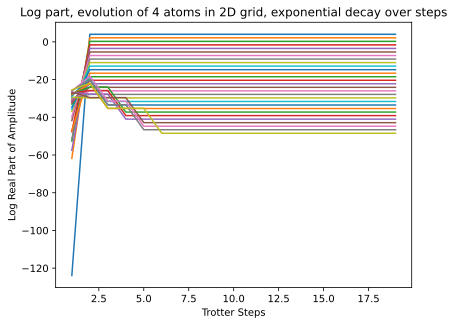

In [ ]:


for i in range(1,len(t_vals)):
    plt.plot(range(1,20), np.log2(np.real(vals[i])), label=f't={t_vals[i]:.2f}')
plt.title("Log part, evolution of 4 atoms in 2D grid, exponential decay over steps")
plt.xlabel("Trotter Steps")
plt.ylabel("Log Real Part of Amplitude")
# plt.legend()
plt.show()

# Calculate the Approximate Decay Rates

In [18]:
# Now plot just the time evolutions at the highest step count
# and calculate the decay rate
final_step_vals = [np.real(vals[i][-1]) for i in range(1,len(t_vals))]
decay_rates = []
# for i in range(1,len(t_vals)):
#     if i == 1:
#         continue
#     y1 = np.log(final_step_vals[i-1])
#     y0 = np.log(final_step_vals[i-2])
#     t1 = t_vals[i]
#     t0 = t_vals[i-1]
#     decay_rate = (y1 - y0) / (t1 - t0)
#     decay_rates.append(decay_rate)
#     print(f"Decay rate between t={t0:.2f} and t={t1:.2f} is {decay_rate:.6f}")

# plt.plot(t_vals[1:], np.log(final_step_vals))
# plt.title("Evolution of 4 atoms in 2D grid at max steps, exponential decay")
# plt.xlabel("Time")
# plt.ylabel("Real Part of Amplitude")
# plt.legend()
# plt.show()

for i in range(1,len(t_vals)):
    if i == len(t_vals)-1:
        y1 = np.log(final_step_vals[i-1])
        y0 = np.log(final_step_vals[i-2])
        t1 = t_vals[i]
        t0 = t_vals[i-1]
        decay_rate = (y1 - y0) / (t1 - t0)
        decay_rates.append(decay_rate)
        print(f"Decay rate between t={t0:.2f} and t={t1:.2f} is {decay_rate:.6f}")

Decay rate between t=2.90 and t=3.00 is -12.556176


## Not sure of functionality

In [16]:
qtn = hamiltonian.to_tensor_network()
outer_inds = qtn.outer_inds()
inner_inds = [ind for ind in qtn.ind_map.keys() if ind not in outer_inds]
    
print(f"  Outer indices (inputs/outputs): {len(outer_inds)}")
print(f"  Inner indices (to contract): {len(inner_inds)}")
    

  Outer indices (inputs/outputs): 8
  Inner indices (to contract): 111
